In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
import tabulate as tb

In [3]:
%matplotlib inline

In [4]:
# !pip install tabulate
# !pip install igraph
# !pip install -U seaborn
# !pip install community
# !pip install python-louvain

In [5]:
import seaborn as sns

In [6]:
def count_comments(df):
    print(f"Dataframe contains: {len(df):,} comments")

In [7]:
sns.set_style("darkgrid")

In [8]:
def estimate_size_of_graph(df):
    authors_videos_group = df.drop(columns=['likes', 'replies'])
    # number of connections
    print("Number of vertices is: {:,}".format(int(authors_videos_group.groupby('author').count().apply(lambda x: comb(x, 2)).sum().values[0])))
    print(f"Number of nodes: {len(df):,}")

In [9]:
from itertools import product
import itertools as it
import igraph
from scipy.special import comb
from community import community_louvain

# Read all comments under videos from News & Poltiics category

#### all files take 12.8 GB RAM

In [12]:
COMMENTS_YT_VIDEOS_DIR = "../../comments_analysis"

df = None
files_to_read = os.listdir(COMMENTS_YT_VIDEOS_DIR)
files_read = 0
for file in [file for file in files_to_read if file[-3:] == "csv"]:
    filepath = os.path.join(COMMENTS_YT_VIDEOS_DIR, file)
    if df is None:
        df = pd.read_csv(filepath)
    else:
        df = pd.concat([df, pd.read_csv(filepath)])
    
    files_read += 1
    percentage_read = 100*(files_read+1)/len(files_to_read)
    if percentage_read % 2.5 == 0:
        print(f"Read {int(percentage_read)}% files")

Read 12% files
Read 25% files
Read 37% files
Read 50% files
Read 62% files
Read 75% files
Read 87% files
Read 100% files


### Read data

In [14]:
df.dtypes

author        int64
video_id     object
likes       float64
replies     float64
dtype: object

In [15]:
count_comments(df)

Dataframe contains: 156,271,825 comments


In [16]:
df.dropna(inplace=True)

In [17]:
count_comments(df)

Dataframe contains: 156,271,606 comments


## Filter out videos with no engagement

In [18]:
size1 = df.shape[0]
df = df[(df.replies>1) & (df.likes>1)]
size2 = df.shape[0]
print(f"Dropped {(size1 - size2):,} comments with 0 engagement")

Dropped 149,578,506 comments with 0 engagement


In [19]:
count_comments(df)

Dataframe contains: 6,693,100 comments


In [20]:
# save comments with engagement
df.to_csv("comments_with_engagement.csv", index=False)

In [11]:
df = pd.read_csv("comments_with_engagement.csv")

# Check Stats of videos

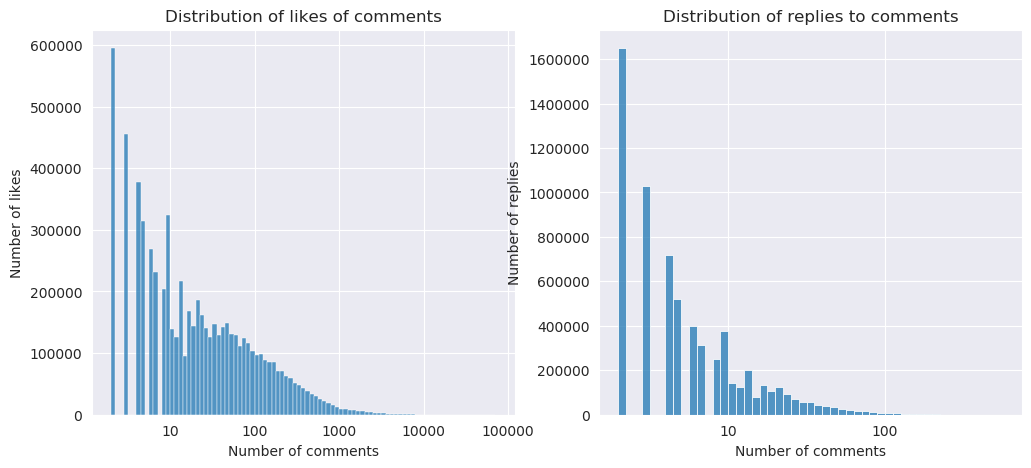

In [21]:
def plot_distributions_stats_video(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # Commentors per video
    sns.histplot(
        ax=axes[0],
        x=data.likes.values,
        binwidth=0.05,
        log_scale=True)
    axes[0].set_title("Distribution of likes of comments");
    axes[0].set_xlabel("Number of comments")
    axes[0].set_ylabel("Number of likes")
    # axes[0].set_xticks([1, 10, 100, 1000, 10000])
    axes[0].get_xaxis().set_major_formatter(ScalarFormatter())
    
    # comments per author
    sns.histplot(
        ax=axes[1],
        x=data.replies.values,
        binwidth=0.05,
        log_scale=True)

    axes[1].set_title("Distribution of replies to comments");
    axes[1].set_xlabel("Number of comments")
    axes[1].set_ylabel("Number of replies")
    # axes[1].set_xticks([1, 10, 100, 1000])
    axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
    plt.show()
    
plot_distributions_stats_video(df)

In [22]:
def print_comments_stats(df):
    print(
        tb.tabulate(
            [
                ["Comments stats",'Median', 'mean', 'min', 'max'],
                ["Likes", df.likes.median(), df.likes.mean(), df.likes.min(), df.likes.max()],
                ["Replies", df.replies.median(), df.replies.mean(), df.replies.min(), df.replies.max()],
            ]
        , headers="firstrow"))

print_comments_stats(df)

Comments stats      Median      mean    min    max
----------------  --------  --------  -----  -----
Likes                   16  84.3347       2  67850
Replies                  4   8.91973      2    533


In [23]:
count_comments(df)

Dataframe contains: 6,693,100 comments


In [24]:
comments_per_video = df.groupby("video_id").author.count()  # this would be weights of the links between nodes

In [25]:
comments_per_video.head()

video_id
----meyKR48     7
---OX3cNabE    45
--0AS6UJDg8     4
--0FoLoWxMo    18
--0t5lElcQQ     3
Name: author, dtype: int64

In [26]:
# drop comments from users that commented the same video
size = df.shape[0]
df = df.drop_duplicates(["author", "video_id"], keep='first')
size2 = df.shape[0]
print(f"Dropped {(size - size2):,} comments from user left more that 2 comments from users")

Dropped 175,529 comments from user left more that 2 comments from users


In [27]:
count_comments(df)

Dataframe contains: 6,517,571 comments


In [28]:
estimate_size_of_graph(df)
print_comments_stats(df)

Number of vertices is: 202,533,868
Number of nodes: 6,517,571
Comments stats      Median      mean    min    max
----------------  --------  --------  -----  -----
Likes                   16  84.8483       2  67850
Replies                  4   8.90919      2    533


## Encode labels

In [29]:
from sklearn import preprocessing

In [30]:
video_id_encoder = preprocessing.LabelEncoder()
video_id_encoder.fit(df.video_id.tolist())

LabelEncoder()

In [31]:
df["video_label"] = video_id_encoder.transform(df.video_id.tolist())

In [32]:
df.shape

(6517571, 5)

In [33]:
df = df.drop(columns=["video_id"])

In [34]:
df.reset_index(drop=True, inplace=True)

In [35]:
df.head()

,author,likes,replies,video_label
0,291407159,267.0,8.0,242817
1,291407159,10.0,2.0,120153
2,291407540,59.0,3.0,288695
3,291407792,7.0,2.0,292043
4,291407792,125.0,17.0,136823


## Plot data

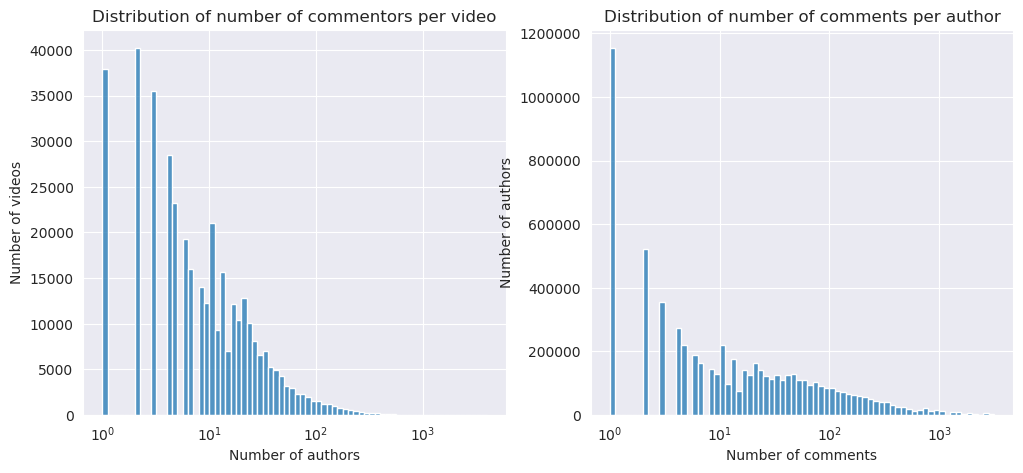

In [36]:
def plot_distributions_commentors(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # Commentors per video
    commentors_per_video = data.groupby('video_label')['author'].count().reset_index()
    sns.histplot(
        ax=axes[0],
        x=commentors_per_video.author,
        binwidth=0.05,
        linewidth=1,
        log_scale=True)
    axes[0].set_title("Distribution of number of commentors per video");
    axes[0].set_xlabel("Number of authors")
    axes[0].set_ylabel("Number of videos")

    # comments per author
    comments_per_author = data.groupby("author")['video_label'].transform('count').reset_index()
    sns.histplot(
        ax=axes[1],
        x=comments_per_author.video_label,
        binwidth=0.05,
        linewidth=1,
        log_scale=True)

    axes[1].set_title("Distribution of number of comments per author");
    axes[1].set_xlabel("Number of comments")
    axes[1].set_ylabel("Number of authors")
    plt.show()
    
plot_distributions_commentors(df)

# Data wrangling

# Filter out comments from video that got less than 2 comments

In [37]:
# Filter out comments from video that got less than 2 comments
size1 = df.shape[0]
df = df.loc[df.groupby("video_label")['author'].transform('count')>=2, :]
size2 = df.shape[0]
print(f"Dropped {(size1 - size2):,} vidoes that have less than 2 comments")
#
# Paper said that they scrapped videos that has more than 10 comments
#

Dropped 37,873 vidoes that have less than 2 comments


In [38]:
# Filter out authors that commented less than 2 comments
size1 = df.shape[0]
df = df.loc[df.groupby("author")['video_label'].transform('count')>=2, :]
size2 = df.shape[0]
print(f"Dropped {(size1 - size2):,} authors that commented less than 2 videos")

Dropped 1,148,363 authors that commented less than 2 videos


In [39]:
count_comments(df)

Dataframe contains: 5,331,335 comments


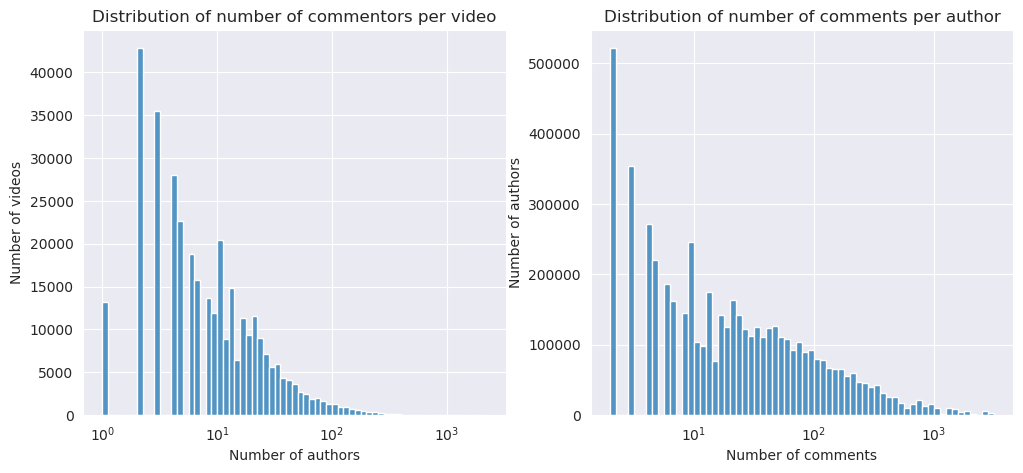

In [40]:
plot_distributions_commentors(df)

In [41]:
estimate_size_of_graph(df)

Number of vertices is: 200,253,072
Number of nodes: 5,331,335


In [42]:
print_comments_stats(df)

Comments stats      Median    mean    min    max
----------------  --------  ------  -----  -----
Likes                   15  78.727      2  67850
Replies                  4   8.966      2    533


In [43]:
author_count = df.groupby('author')['video_label'].count()
print("Maximum number of videos that single user commented under: {}".format(author_count.max()))
print("Minimum number of videos that single user commented under: {}".format(author_count.min()))
print("Mean number of videos that single user commented under: {}".format(author_count.mean()))
print("Median number of videos that single user commented under: {}".format(author_count.median()))

Maximum number of videos that single user commented under: 2891
Minimum number of videos that single user commented under: 2
Mean number of videos that single user commented under: 7.750373974568276
Median number of videos that single user commented under: 3.0


In [44]:
size1 = df.shape[0]
df_2 = df[(df.replies>df.replies.median()) & (df.likes>df.likes.median())]
size2 = df_2.shape[0]
print(f"Dropped {(size1 - size2):,} comments that got less replies than the median, and likes then the median")

Dropped 3,592,550 comments that got less replies than the median, and likes then the median


In [45]:
estimate_size_of_graph(df_2)
print_comments_stats(df_2)

Number of vertices is: 31,651,303
Number of nodes: 1,738,785
Comments stats      Median      mean    min    max
----------------  --------  --------  -----  -----
Likes                   81  200.68       16  67850
Replies                 11   18.3113      5    533


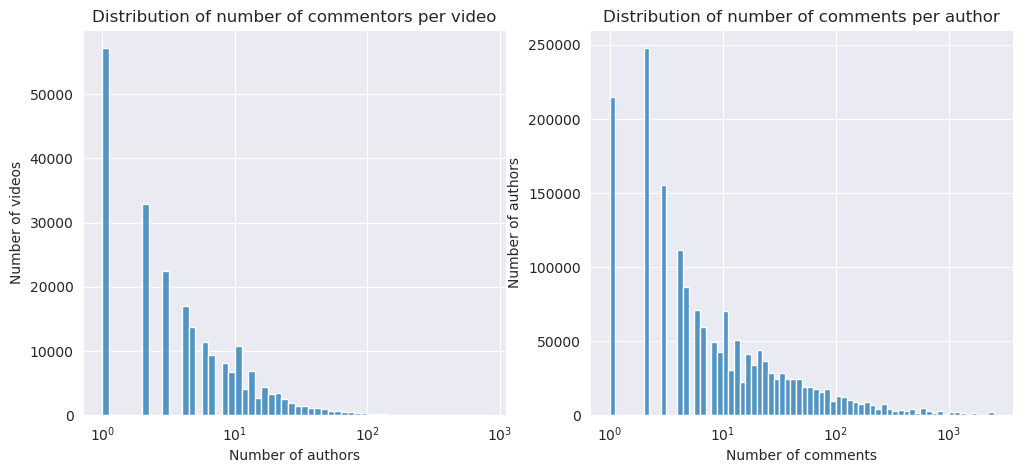

In [46]:
plot_distributions_commentors(df_2)

In [47]:
# Filter out authors that commented less than 2 comments
size1 = df_2.shape[0]
df_2 = df_2.loc[df_2.groupby("author")['video_label'].transform('count')>=2, :]
size2 = df_2.shape[0]
print(f"Dropped {(size1 - size2):,} authors that commented less than 2 videos")

# Filter out comments from video that got less than 2 comments
size1 = df_2.shape[0]
df_2 = df_2.loc[df_2.groupby("video_label")['author'].transform('count')>=2, :]
size2 = df_2.shape[0]
print(f"Dropped {(size1 - size2):,} vidoes that have less than 2 comments")

Dropped 214,935 authors that commented less than 2 videos
Dropped 57,657 vidoes that have less than 2 comments


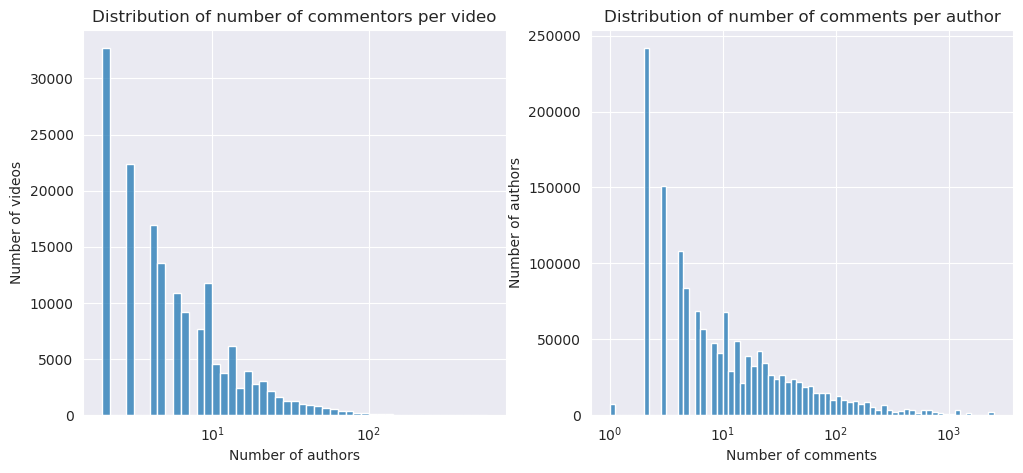

In [48]:
plot_distributions_commentors(df_2)

In [89]:
size1 = df_2.shape[0]
df_2 = df_2.loc[df_2.groupby("author")['video_label'].transform('count')>=2, :]
size2 = df_2.shape[0]
print(f"Dropped {(size1 - size2):,} authors that commented less than 2 videos")

Dropped 19,335 authors that commented less than 2 videos


In [49]:
estimate_size_of_graph(df_2)
print_comments_stats(df_2)

Number of vertices is: 29,066,132
Number of nodes: 1,466,193
Comments stats      Median      mean    min    max
----------------  --------  --------  -----  -----
Likes                   86  206.082      16  67850
Replies                 11   18.7602      5    533


In [90]:
df_2.video_label.unique().shape

(346289,)

In [51]:
df_2.to_csv("comments_with_engagement_filtered.csv", index=False)

## Decode labels and save the mapping

In [72]:
df_2['video_id'] = video_id_encoder.inverse_transform(df_2.video_label)
df_2[['video_id', 'video_label']].to_csv('videos_mapping.csv', index=False)

# Do a graph!

In [77]:
authors_videos_group = df_2.drop(columns=['likes', 'replies', 'video_id'])

In [78]:
authors_videos_group.shape

(1466193, 2)

In [79]:
estimate_size_of_graph(df_2)

Number of vertices is: 29,066,132
Number of nodes: 1,466,193


### Create source-target link dataframe

In [55]:
import time

In [56]:
start_time = time.time()

combinations = list()
for _, g_data in authors_videos_group.groupby('author'):
    # create combinations of two pairs
    combinations.extend(list(it.combinations(g_data.video_label.values, 2)))

links = pd.DataFrame(combinations, dtype='int64')
links.rename(columns={0: "source", 1:"target"}, inplace=True)

print(f"Finished after: {(time.time()-start_time):.4f}s")

Finished after: 39.2456s


In [81]:
links = pd.DataFrame(combinations, dtype='int64')

In [ ]:
# add weights 
start_time = time.time()
links['weight'] = links.apply(lambda x: comments_per_video.iloc[x.source]+comments_per_video.iloc[x.target], axis=1)
print(f"Finished after: {(time.time()-start_time):.4f}s")

In [82]:
links

,0,1
0,33645,178718
1,33645,261586
2,178718,261586
3,146450,107483
4,146450,58361
...,...,...
29066127,241312,142207
29066128,241312,180107
29066129,311310,142207
29066130,311310,180107


In [64]:
print('done')

done


In [65]:
links.to_csv("links_weightend.csv", index=False)

In [89]:
f"{links.shape[0]:,}"

'29,066,132'

In [90]:
estimate_size_of_graph(df_2)

Number of vertices is: 29,066,132
Number of nodes: 1,466,193


In [68]:
import networkx as nx

In [69]:
start_time = time.time()
graph = nx.from_pandas_edgelist(links,
                                edge_attr='weight')
print(f"Finished after: {(time.time()-start_time):.4f}s")

Finished after: 96.7452s


In [83]:
start_time = time.time()
communities = community_louvain.best_partition(graph, weight='weight')
print(f"Finished after: {(time.time()-start_time):.4f}s")

Finished after: 1953.5137s


In [84]:
print('done')

done


During computation it went up to 46% RAM on 128GB AWS Sagemaker notebook

In [85]:
labels = pd.DataFrame.from_dict(communities, orient='index').reset_index().rename(columns={"index":"video_label", 0: "cluster"})

In [93]:
labels.video_label.unique().shape

(163316,)

## Decode labels

In [94]:
df_2['video_id'] = video_id_encoder.inverse_transform(df_2.video_label)

In [95]:
labels['video_id'] = video_id_encoder.inverse_transform(labels.video_label)

In [96]:
links['source_id'] = video_id_encoder.inverse_transform(links.source)
links['target_id'] = video_id_encoder.inverse_transform(links.target)

In [97]:
df_2.shape, links.shape, labels.shape

((1466193, 5), (29066132, 4), (163316, 3))

### Save files

In [98]:
df_2.to_csv("df_filtered_weighted.csv", index=False)

In [99]:
labels.to_csv("labeled_communities_weighted.csv", index=False)

In [100]:
links.to_csv("links_weighted.csv", index=False)